## Anomaly Detection - Project

### Authors: Norbert Klockiewicz, Kacper Majchrzak, Patryk Kożuch

#### Based on: <a href="https://arxiv.org/pdf/1802.04431.pdf">Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding</a>


Imports


In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools as mit
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Dense, Activation, Dropout, LSTM

In [14]:
CHANNEL = "D-13"

### Class channel - load and prepare data to train model


In [15]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [16]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

### Class Model - create and train recurrent neural network


In [17]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [18]:
model = Model(new_channel)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-14 11:01:44.486125: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 11:01:44.486432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/35


2024-04-14 11:01:46.755263: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-14 11:01:50.195139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:01:50.874471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:01:55.981386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:02:00.518459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:03:00.213793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.4363

2024-04-14 11:06:03.222086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:06:03.399531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:06:06.757379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 275s 10s/step - loss: 0.4363 - val_loss: 0.0082
Epoch 2/35
16/16 [==============================] - 5s 323ms/step - loss: 0.0773 - val_loss: 0.0054
Epoch 3/35
16/16 [==============================] - 5s 297ms/step - loss: 0.0468 - val_loss: 8.5651e-04
Epoch 4/35
16/16 [==============================] - 7s 450ms/step - loss: 0.0340 - val_loss: 6.9458e-04
Epoch 5/35
16/16 [==============================] - 5s 311ms/step - loss: 0.0273 - val_loss: 6.7268e-04
Epoch 6/35
16/16 [==============================] - 5s 314ms/step - loss: 0.0231 - val_loss: 6.1626e-04
Epoch 7/35
16/16 [==============================] - 5s 304ms/step - loss: 0.0199 - val_loss: 4.3251e-04
Epoch 8/35
16/16 [==============================] - 5s 310ms/step - loss: 0.0174 - val_loss: 4.3018e-04
Epoch 9/35
16/16 [==============================] - 6s 391ms/step - loss: 0.0152 - val_loss: 6.9671e-04
Epoch 10/35
16/16 [==============================] - 6s 388ms/step - loss: 0.0133 -

In [19]:
model.batch_predict(new_channel)

2024-04-14 11:07:45.887982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:07:46.052741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-14 11:07:49.455375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


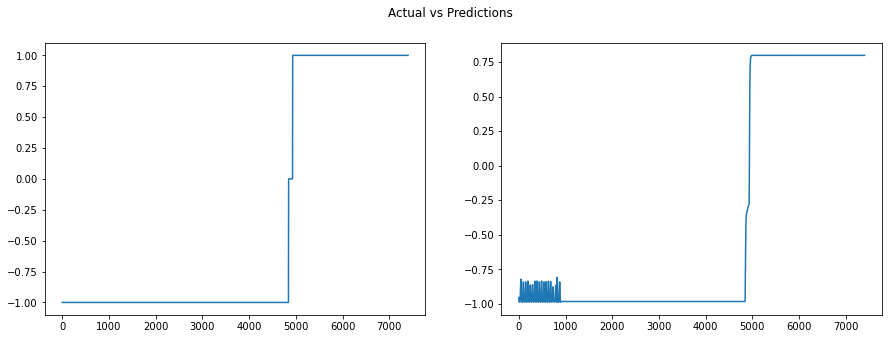

In [20]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 5)

fig.suptitle("Actual vs Predictions")

ax[0].plot(new_channel.y_test[:, 0])

ax[1].plot(new_channel.y_hat)

### Class Plotter - visualize input data, predictions and errors


In [21]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            if max(rect[0], start) <  min(rect[1], end):
                plt.axvspan(max(rect[0], start), min(rect[1], end), alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(error))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

    def plot_detected_anomalies(self, d_anomalies, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        for rect in d_anomalies:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

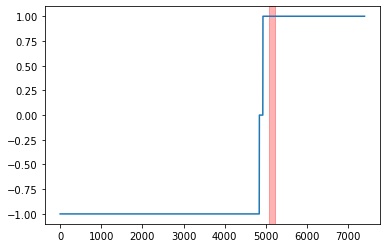

In [22]:
plotter = Plotter(new_channel)
plotter.plot_predictions(plot_real_data=True)
# plotter.plot_custom_range_predictions(4900, 7000)

### Calculate error between real and predicted data, create smoothed error


In [37]:
class ErrorWindow:
    def __init__(self, channel, e_s, window_size, window_number):
        self.channel = channel
        self.e_s = e_s
        self.window_num = window_number
        self.window_size = window_size
        self.E_seq = np.array([])
        
        self.mean = np.mean(self.e_s)
        self.std = np.std(self.e_s)
        self.epsilon = self.mean + 12 * self.std
        self.indices_anomalies = np.array([])
        self.anom_scores = []
        self.non_anom_max = float('-inf')

    def find_anomalies(self):
        max_score = float('-inf')

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean + (self.std * z)
            below_epsilon = self.e_s[self.e_s < epsilon]

            delta_mean = self.mean - np.mean(below_epsilon)
            delta_std = self.std - np.std(below_epsilon)
            e_a = self.e_s[self.e_s >= epsilon]

            if len(e_a) > 0:
                anom = np.argwhere(self.e_s >= epsilon).reshape(-1)
                E_seq =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq_len = len(E_seq)
                
                score = ((delta_mean/self.mean) + (delta_std/self.std)) / (E_seq_len**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    self.epsilon = epsilon
                    self.E_seq = E_seq
                    # I have no idea why this is here
                    # anom = anom[anom >= len(self.e_s) - 70]
                    self.indices_anomalies = anom
                    self.non_anom_max = max(below_epsilon)
                    
        return self.epsilon
    
    def prune_anomalies(self):
        if len(self.E_seq) == 0:
            return
        
        non_anom_max = self.non_anom_max
        
        E_seq_max = []
        for e_seq in self.E_seq:
            E_seq_max.append(max(self.e_s[e_seq[0]: e_seq[-1] + 1]))

        E_seq_max_sorted = np.sort(E_seq_max)[::-1]
        E_seq_max_sorted = np.append(E_seq_max_sorted, non_anom_max)

        i_to_remove = np.array([], dtype=int)

        for i in range(len(E_seq_max_sorted)-1):
            if (E_seq_max_sorted[i] - E_seq_max_sorted[i + 1]) / E_seq_max_sorted[i] < 0.13:
                i_to_remove = np.append(i_to_remove, np.argwhere(E_seq_max == E_seq_max_sorted[i]))
            else:
                i_to_remove = np.array([])
        
        i_to_remove[::-1].sort()

        if len(i_to_remove) > 0:
            self.E_seq = np.delete(self.E_seq, i_to_remove, axis=0)
        
        if len(self.E_seq) == 0:
            self.indices_anomalies = np.array([])
            return
        
        indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1] + 1) for e_seq in self.E_seq])

        mask = np.isin(self.indices_anomalies, indices_to_keep)
        self.indices_anomalies = self.indices_anomalies[mask]
        

    def score_anomalies(self, prior_idx):

        groups = [list(group) for group in mit.consecutive_groups(self.indices_anomalies)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean + self.std) for i in
                         range(e_seq[0], e_seq[-1] + 1)])

            score_dict['score'] = score
            self.anom_scores.append(score_dict)

In [30]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        # self.error = np.abs(channel.y_test[:, 0] - channel.y_hat)
        self.error = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

        self.window_size = 30
        self.batch_size = 70

        self.n_windows = int((channel.y_test.shape[0] - (self.batch_size * self.window_size)) / self.batch_size)
        self.i_anom = np.array([])
        self.anom_scores = []
        self.E_seq = []
        self.epsilons = []


    def detect_anomalies(self):

        for i in range(self.n_windows + 1):
            prior_idx = i * self.batch_size
            idx = self.window_size * self.batch_size + prior_idx
            window = ErrorWindow(self.channel, self.e_s[prior_idx:idx], self.window_size, i)
            
            self.epsilons.append(window.find_anomalies())
            window.prune_anomalies()
            window.score_anomalies(prior_idx)

            self.i_anom = np.append(self.i_anom, window.indices_anomalies + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores


        if len(self.anom_scores) > 0:
            self.anom_scores = sorted(self.anom_scores, key=lambda x: x['score'], reverse=True)
            self.check_scores()

    def check_scores(self):
        self.anom_scores = sorted(self.anom_scores, key=lambda x: x['start_idx'])
        for i in range(len(self.anom_scores)):
            if self.anom_scores[i]['score'] > 0.1:
                self.E_seq.append([self.anom_scores[i]['start_idx'], self.anom_scores[i]['end_idx']])

        E_seq = [self.E_seq[0]]
        for s, e in self.E_seq[1:]:
            if max(s, E_seq[-1][0]) <= min(e, E_seq[-1][1]) or s == E_seq[-1][1] + 1:
                E_seq[-1] = [min(s, E_seq[-1][0]), max(e, E_seq[-1][1])]
            else:
                E_seq.append([s, e])
        self.E_seq = E_seq
        # shift data to match the original data
        self.E_seq = [(e_seq[0] + 250,
                           e_seq[1] + 250) for e_seq in self.E_seq]

In [38]:
errors = Errors(new_channel)
errors.detect_anomalies()
max(errors.anom_scores, key=lambda x: x['score']), errors.E_seq

({'start_idx': 4849, 'end_idx': 4899, 'score': 2.945162847665633},
 [(1090, 1160), (5099, 5149), (5185, 5217)])

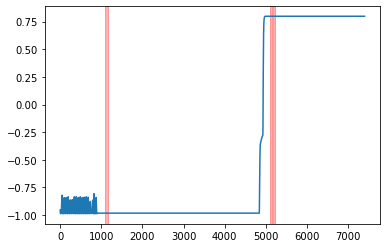

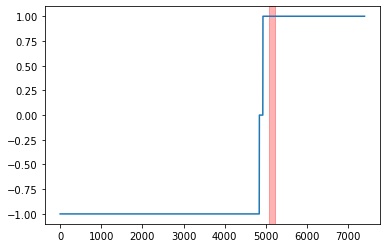

In [43]:
plotter.plot_detected_anomalies(errors.E_seq, plot_real_data=False)
plotter.plot_predictions(plot_real_data=True)